In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [35]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess your data here, ensuring it is scaled and split into training and test sets.
# Assume we have `X_train`, `y_train`, `X_test`, `y_test` after preprocessing.

# Load the dataset
df = pd.read_csv('AAPL.csv')

# Select features to use for prediction
features = df[['open', 'high', 'low', 'close', 'volume', 'adjclose', 'dividends', 'splits']]

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Function to create a dataset with look back
def create_dataset(data, look_back=10):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        Y.append(data[i + look_back, 3])  # index 3 is the 'close' column
    return np.array(X), np.array(Y)

# Split into train and test sets
train_size = int(len(scaled_features) * 0.8)
test_size = len(scaled_features) - train_size
train, test = scaled_features[0:train_size, :], scaled_features[train_size:len(scaled_features), :]

# Create the dataset with look back
look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device)

# Create DataLoader instances
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

In [36]:

# Define the BiLSTM with Attention Model
class BiLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(BiLSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        
        # Attention layer
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def attention_net(self, lstm_output):
        # lstm_output shape: (batch_size, seq_length, hidden_dim * 2)
        attn_weights = torch.tanh(self.attention(lstm_output))  # (batch_size, seq_length, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # (batch_size, seq_length, 1)
        
        # New attention implementation
        context_vector = torch.bmm(attn_weights.transpose(2, 1), lstm_output)  # (batch_size, 1, hidden_dim * 2)
        context_vector = context_vector.squeeze(1)  # (batch_size, hidden_dim * 2)
        return context_vector

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device)
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device)
        
        # Forward pass through LSTM layer
        lstm_out, _ = self.lstm(x, (h_0, c_0))  # lstm_out shape: (batch_size, seq_length, hidden_dim * 2)
        
        # Forward pass through Attention layer
        attn_output = self.attention_net(lstm_out)  # attn_output shape: (batch_size, hidden_dim * 2)
        
        # Forward pass through Fully connected layer
        output = self.fc(attn_output)  # output shape: (batch_size, output_dim)
        return output

# Define hyperparameters
input_dim = X_train.shape[2]
hidden_dim = 64
output_dim = 1
num_layers = 2

# Initialize the model
model = BiLSTMAttention(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [37]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for data, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([43, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 0.0342
Epoch [2/10], Loss: 0.0214
Epoch [3/10], Loss: 0.0174
Epoch [4/10], Loss: 0.0321
Epoch [5/10], Loss: 0.0173
Epoch [6/10], Loss: 0.0250
Epoch [7/10], Loss: 0.0262
Epoch [8/10], Loss: 0.0340
Epoch [9/10], Loss: 0.0259
Epoch [10/10], Loss: 0.0229


In [38]:
# Test the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_np, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_np, predictions))
    r2 = r2_score(y_test_np, predictions)

print(f'MAE: {mae}, RMSE: {rmse}, R^2: {r2}')

MAE: 1.955022931098938, RMSE: 2.380251169204712, R^2: -2.066247526551352


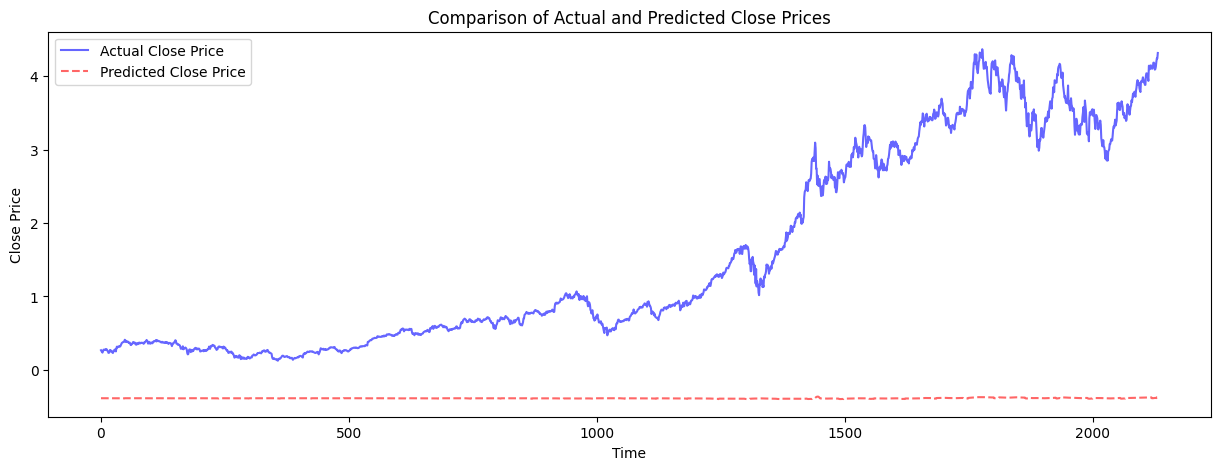

In [39]:
# Assuming `predictions` and `actuals` are lists or numpy arrays containing the predicted and actual close prices.
  # Replace with your model's predictions
actuals = y_test_tensor.cpu().numpy()     # Replace with the actual close prices

# Create a plot of the predicted vs actual values.
plt.figure(figsize=(15, 5))
plt.plot(actuals, label='Actual Close Price', color='blue', alpha=0.6)
plt.plot(predictions, label='Predicted Close Price', color='red', linestyle='--', alpha=0.6)

# Add title and labels
plt.title('Comparison of Actual and Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()